In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_051_f254.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_079_f334.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_080_f397.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_088_f1073.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_020_f146.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_026_f751.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_054_f643.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_026_f269.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_062_f84.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_056_f33.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_010_f368.jpg
/kaggle/input/frames-film-vietnam-dataset/Frame_Test/Dia_Dao/scene_006_f247.jpg
/kaggle/input/frames-film-vietnam-dataset

In [ ]:
!pip install -q faiss-cpu
!pip install -q tensorflow==2.18.0
!pip install -q skl2onnx onnx onnxruntime

In [2]:
import tensorflow as tf
import os

# Kiểm tra phiên bản TensorFlow
print(f"TensorFlow version: {tf.__version__}")

# Cấu hình memory growth để sử dụng GPU hiệu quả
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Tìm thấy {len(gpus)} GPU:")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")
    
    # Cấu hình memory growth
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Một số tùy chọn để tối ưu hiệu suất cho GPU T4
        os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
        os.environ['TF_GPU_THREAD_COUNT'] = '2'  # Tương ứng với số GPU
        
        # Hiển thị các GPU logic
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Số lượng GPU vật lý: {len(gpus)}, số lượng GPU logic: {len(logical_gpus)}")
        
        # Thông tin chi tiết về GPU
        from tensorflow.python.client import device_lib
        local_device_protos = device_lib.list_local_devices()
        gpu_list = [x.name for x in local_device_protos if x.device_type == 'GPU']
        print(f"Danh sách GPU: {gpu_list}")
        
        # Hiển thị thông tin CUDA và cuDNN
        build_info = tf.sysconfig.get_build_info()
        print(f"CUDA version: {build_info.get('cuda_version', 'N/A')}")
        print(f"cuDNN version: {build_info.get('cudnn_version', 'N/A')}")
        
        # Kiểm tra xem GPU có thực sự được sử dụng hay không
        print("\nXác nhận GPU đang hoạt động bằng phép tính nhỏ:")
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
            c = tf.matmul(a, b)
            print(f"Tính toán trên GPU: {c}")
            print(f"Đang chạy trên thiết bị: {c.device}")
    
    except RuntimeError as e:
        print(f"Lỗi khi cấu hình GPU: {e}")
else:
    print("Không tìm thấy GPU! Đang sử dụng CPU.")
    
    # Kiểm tra thông tin CPU
    cpu_devices = tf.config.list_physical_devices('CPU')
    print(f"Tìm thấy {len(cpu_devices)} CPU: {cpu_devices}")

2025-06-09 06:25:34.663538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749450334.908842      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749450334.985995      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Không tìm thấy GPU! Đang sử dụng CPU.
Tìm thấy 1 CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-06-09 06:25:49.921659: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
import glob
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd
import os
from PIL import Image
import warnings
import gc
import numpy as np
import csv
import time
import seaborn as sns
from tqdm import tqdm 
import shutil

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Dropout, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Resizing
from tensorflow.keras.layers import MaxPooling2D, Activation, BatchNormalization, Attention, Reshape, RepeatVector, Lambda, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib

import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Bỏ qua các cảnh báo
warnings.filterwarnings("ignore")

# In phiên bản TensorFlow hiện tại
print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed=0):
    # Thiết lập seed để đảm bảo tính tái lập (reproducibility)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Gọi hàm seed_everything để thiết lập seed mặc định
seed_everything()

TensorFlow Version 2.18.0


# Trực quan dữ liệu

In [4]:
def count_images_per_folder(root_dir, image_extensions=None):
    if image_extensions is None:
        image_extensions = ['.jpg']

    total = 0
    for subdir, dirs, files in os.walk(root_dir):
        count = sum(1 for file in files if any(file.lower().endswith(ext) for ext in image_extensions))
        if count > 0:
            relative_path = os.path.relpath(subdir, root_dir)
            # print(f"Thư mục '{relative_path}': {count} ảnh")
            total += count

    print(f"==> Tổng số ảnh: {total}")

print("====Thư mục Train====")
folder_train_path = '/kaggle/input/processed-frames-224/Process_Frames_1/Train'
count_images_per_folder(folder_train_path)

print("====Thư mục Test====")
folder_test_path = '/kaggle/input/processed-frames-224/Process_Frames_1/Test'
count_images_per_folder(folder_test_path)

====Thư mục Train====
==> Tổng số ảnh: 89852
====Thư mục Test====
==> Tổng số ảnh: 27612


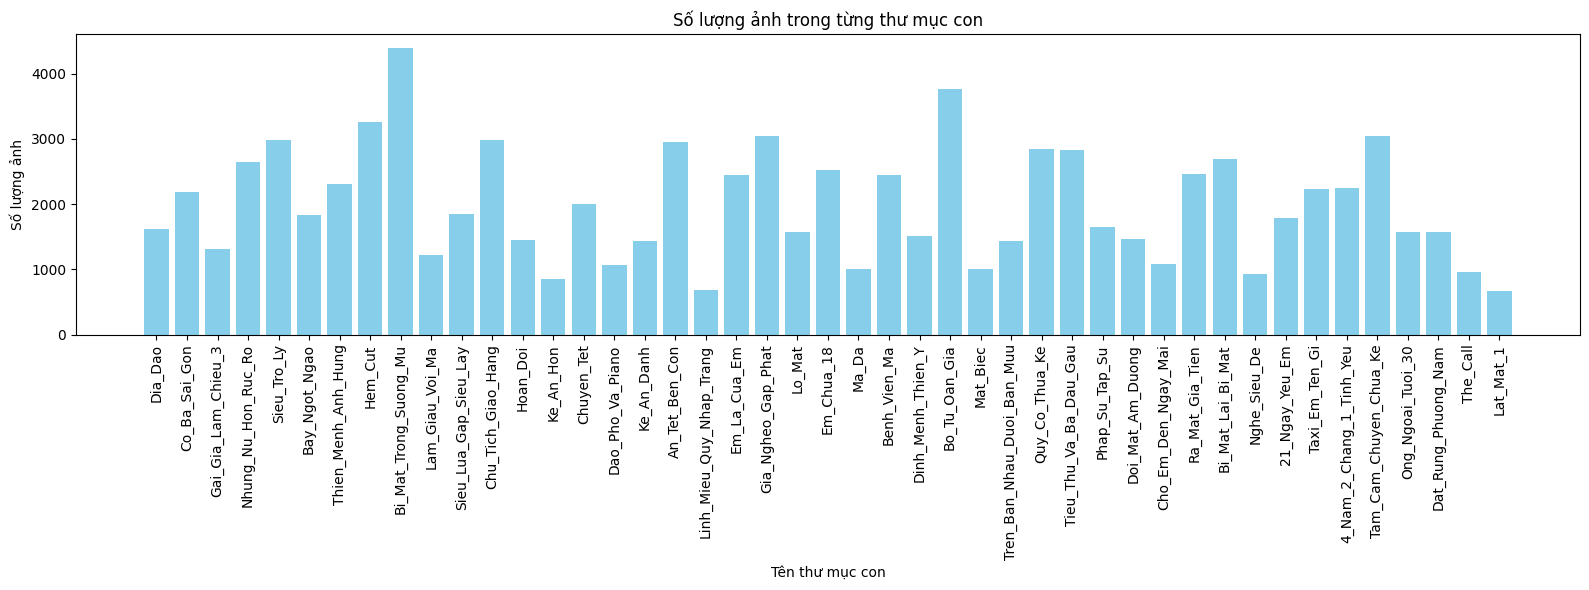

In [5]:
def count_images_per_folder(root_dir, image_extensions=None):
    if image_extensions is None:
        image_extensions = ['.jpg']

    folder_counts = {}
    for subdir, dirs, files in os.walk(root_dir):
        if subdir == root_dir:
            continue  # bỏ qua thư mục gốc
        count = sum(1 for file in files if any(file.lower().endswith(ext) for ext in image_extensions))
        if count > 0:
            folder_name = os.path.basename(subdir)
            folder_counts[folder_name] = count

    return folder_counts

def plot_image_counts(folder_counts):
    folders = list(folder_counts.keys())
    counts = list(folder_counts.values())

    plt.figure(figsize=(16, 6))
    plt.bar(folders, counts, color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel('Tên thư mục con')
    plt.ylabel('Số lượng ảnh')
    plt.title('Số lượng ảnh trong từng thư mục con')
    plt.tight_layout()
    plt.show()

# Tập Train
counts = count_images_per_folder(folder_train_path)
plot_image_counts(counts)

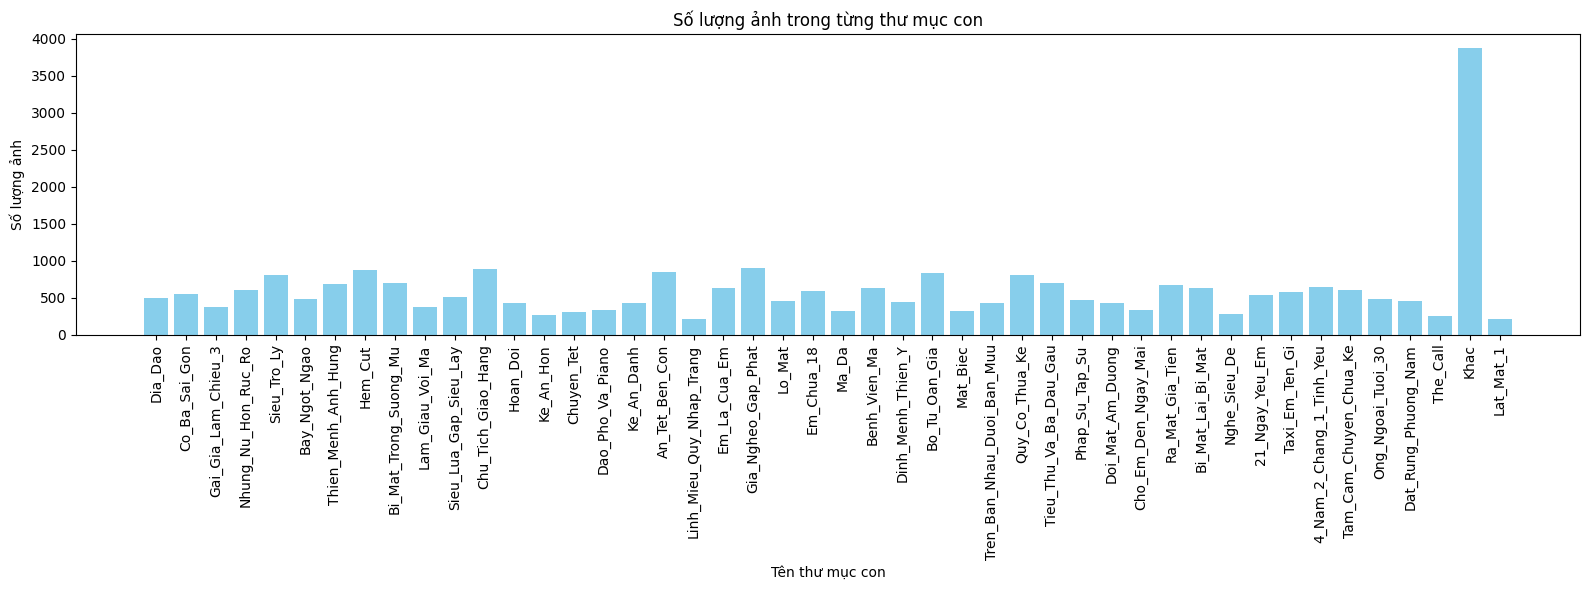

In [6]:
# Tập Test
counts = count_images_per_folder(folder_test_path)
plot_image_counts(counts)

# Tạo tập dữ liệu

In [2]:
image_size = 224
n_classes = 45
batch_size = 128

classes = {
    1: "21_Ngay_Yeu_Em",
    2: "4_Nam_2_Chang_1_Tinh_Yeu",
    3: "An_Tet_Ben_Con",
    4: "Bay_Ngot_Ngao",
    5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat",
    7: "Bi_Mat_Trong_Suong_Mu",
    8: "Bo_Tu_Oan_Gia",
    9: "Cho_Em_Den_Ngay_Mai",
    10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet",
    12: "Co_Ba_Sai_Gon",
    13: "Dao_Pho_Va_Piano",
    14: "Dat_Rung_Phuong_Nam",
    15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y",
    17: "Doi_Mat_Am_Duong",
    18: "Em_Chua_18",
    19: "Em_La_Cua_Em",
    20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat",
    22: "Hem_Cut",
    23: "Hoan_Doi",
    24: "Ke_An_Danh",
    25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma",
    27: "Lat_Mat_1",
    28: "Quy_Cau",
    29: "Lo_Mat",
    30: "Ma_Da",
    31: "Mat_Biec",
    32: "Nghe_Sieu_De",
    33: "Nhung_Nu_Hon_Ruc_Ro",
    34: "Ong_Ngoai_Tuoi_30",
    35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke",
    37: "Ra_Mat_Gia_Tien",
    38: "Sieu_Lua_Gap_Sieu_Lay",
    39: "Sieu_Tro_Ly",
    40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi",
    42: "The_Call",
    43: "Thien_Menh_Anh_Hung",
    44: "Tieu_Thu_Va_Ba_Dau_Gau",
    45: "Tren_Ban_Nhau_Duoi_Ban_Muu"
}

In [7]:
train_path = '/kaggle/input/processed-frames-224/Process_Frames_1/Train'

train_df = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',  
    seed=1,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False, 
)

# Chuẩn hóa ảnh
# normalization_layer = L.Rescaling(1./255)

# train_df = train_df.map(lambda x, y: (normalization_layer(x), y))

Found 89852 files belonging to 45 classes.


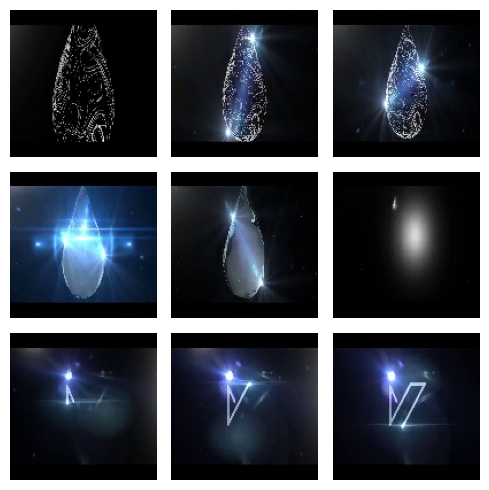

In [10]:
images, labels = next(iter(train_df))  

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.flatten()

for img, ax in zip(images[:9], axes): 
    ax.imshow(img.numpy().astype("uint8"))  
    ax.axis('off')

plt.tight_layout()
plt.show()

# Xóa file trong thư mục

In [18]:
def delete_all_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # xóa file hoặc symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # xóa thư mục và toàn bộ nội dung bên trong
        except Exception as e:
            print(f"Không thể xóa {file_path}: {e}")

# Ví dụ:
folder = "/kaggle/working/"
delete_all_in_folder(folder)

In [14]:
gc.collect()
tf.keras.backend.clear_session()

# Resnet50 + FAISS Index

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Số batch
num_batches = tf.data.experimental.cardinality(train_df).numpy()

strategy = tf.distribute.MirroredStrategy()

# Khởi tạo model trong context của strategy
with strategy.scope():
    base_model_resnet50 = ResNet50(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Nơi lưu đặc trưng và nhãn
all_features = []
all_labels = []

# Lặp qua từng batch
for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features"):
    images_pp = preprocess_input(images)
    features_batch = base_model_resnet50(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

# Đánh nhãn ứng với đặc trưng
features_array = np.concatenate(all_features, axis=0)
labels_array = np.concatenate(all_labels, axis=0)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Extracting features: 100%|██████████| 702/702 [02:49<00:00,  4.14it/s]


In [11]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

Đã thêm 89852 vector đã chuẩn hóa vào FAISS index.


In [12]:
# Đọc lại FAISS index và nhãn
index = faiss.read_index("faiss_features.index")
labels_array = np.load("faiss_labels.npy")

✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 89852
   - Kích thước vector: 2048


Testing with FAISS:   0%|          | 0/27612 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1748175988.972742     110 service.cc:148] XLA service 0x7f8cdc04c250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748175988.973728     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748175991.140851     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Testing with FAISS: 100%|██████████| 27612/27612 [1:03:58<00:00,  7.19it/s]



✅ Accuracy: 87.11%
✅ Đúng: 24054 / ❌ Sai: 3558

⏱️ Thời gian xử lý trung bình: 0.1381 giây/ảnh
⏱️ Tổng thời gian xử lý: 3814.25 giây cho 27612 ảnh


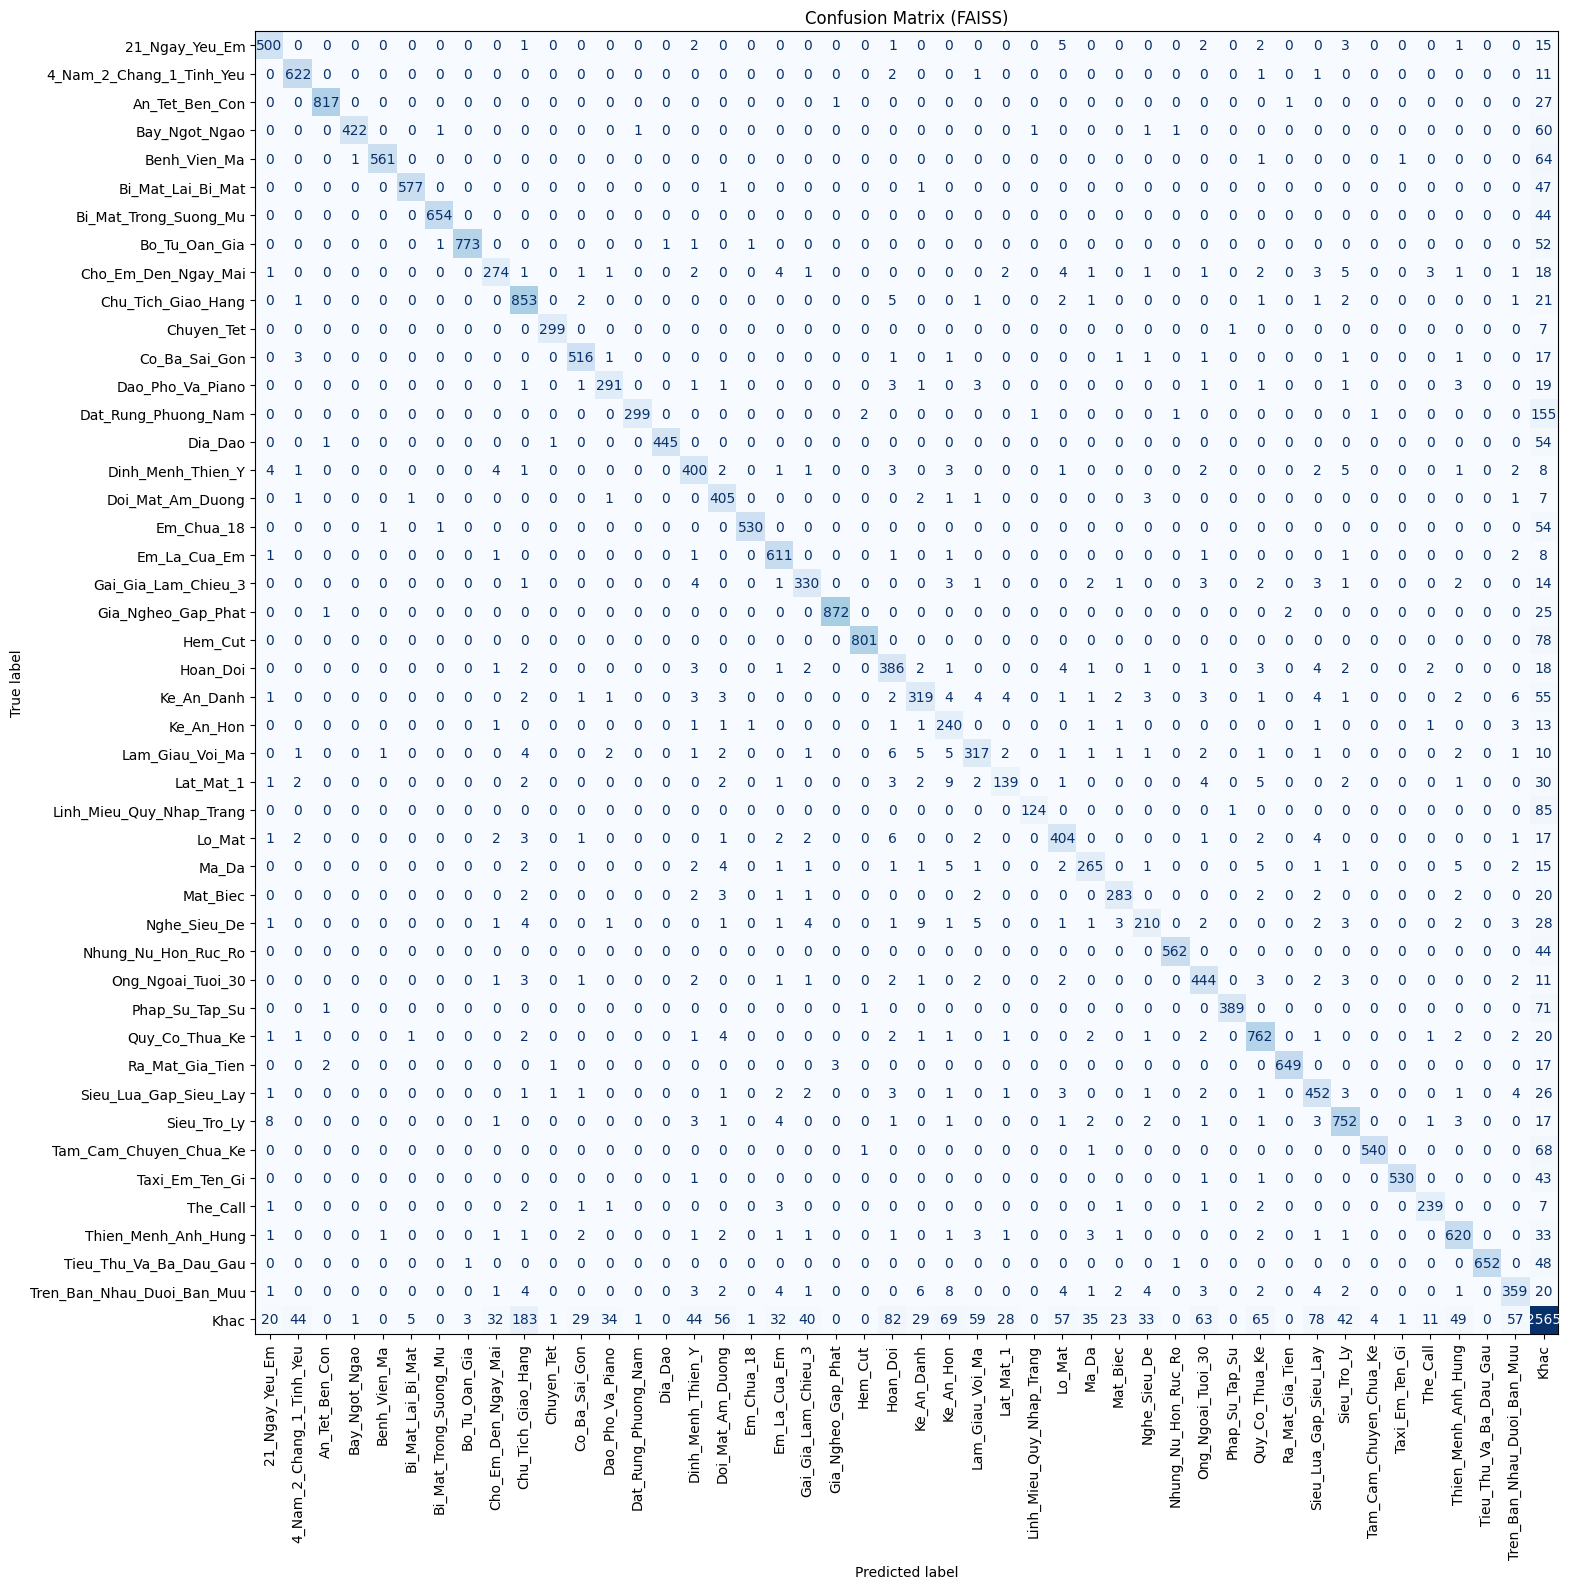


🖼️ Confusion matrix đã được lưu vào 'confusion_matrix_faiss.jpg'

📄 Classification Report:
                            precision    recall  f1-score  accuracy
21_Ngay_Yeu_Em               0.920810  0.939850  0.930233  0.871143
4_Nam_2_Chang_1_Tinh_Yeu     0.917404  0.974922  0.945289  0.871143
An_Tet_Ben_Con               0.993917  0.965721  0.979616  0.871143
Bay_Ngot_Ngao                0.995283  0.866530  0.926454  0.871143
Benh_Vien_Ma                 0.994681  0.893312  0.941275  0.871143
Bi_Mat_Lai_Bi_Mat            0.988014  0.921725  0.953719  0.871143
Bi_Mat_Trong_Suong_Mu        0.995434  0.936963  0.965314  0.871143
Bo_Tu_Oan_Gia                0.994852  0.932449  0.962640  0.871143
Cho_Em_Den_Ngay_Mai          0.856250  0.837920  0.846986  0.871143
Chu_Tich_Giao_Hang           0.793488  0.957351  0.867752  0.871143
Chuyen_Tet                   0.986799  0.973941  0.980328  0.871143
Co_Ba_Sai_Gon                0.928058  0.948529  0.938182  0.871143
Dao_Pho_Va_Piano        

In [12]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/processed-frames-224/Process_Frames_1/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.8  

# ==== Load mô hình và FAISS index ====
# Load mô hình ResNet50 
model = ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu",
    46: "Khac"
}

class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")

# EfficientNetB4 + FAISS Index

In [7]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input

# Số batch
num_batches = tf.data.experimental.cardinality(train_df).numpy()

strategy = tf.distribute.MirroredStrategy()

# Khởi tạo EfficientNetB4 trong context của strategy
with strategy.scope():
    base_model_efficientnetb4 = EfficientNetB4(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Nơi lưu đặc trưng và nhãn
all_features = []
all_labels = []

# Lặp qua từng batch
for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features with EfficientNetB4"):
    images_pp = preprocess_input(images)
    features_batch = base_model_efficientnetb4(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

# Kết hợp đặc trưng và nhãn
features_array = np.concatenate(all_features, axis=0)
labels_array = np.concatenate(all_labels, axis=0)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Extracting features with EfficientNetB4: 100%|██████████| 702/702 [05:52<00:00,  1.99it/s]


In [8]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

Đã thêm 89852 vector đã chuẩn hóa vào FAISS index.


In [24]:
# Đọc lại FAISS index và nhãn
index = faiss.read_index("faiss_features.index")
labels_array = np.load("faiss_labels.npy")

✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 89852
   - Kích thước vector: 1792


Testing with FAISS:   0%|          | 0/27612 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1748226114.867474     110 service.cc:148] XLA service 0x7853cc004a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748226114.868447     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748226120.223749     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Testing with FAISS: 100%|██████████| 27612/27612 [1:00:42<00:00,  7.58it/s]



✅ Accuracy: 76.31%
✅ Đúng: 21071 / ❌ Sai: 6541

⏱️ Thời gian xử lý trung bình: 0.1311 giây/ảnh
⏱️ Tổng thời gian xử lý: 3620.22 giây cho 27612 ảnh


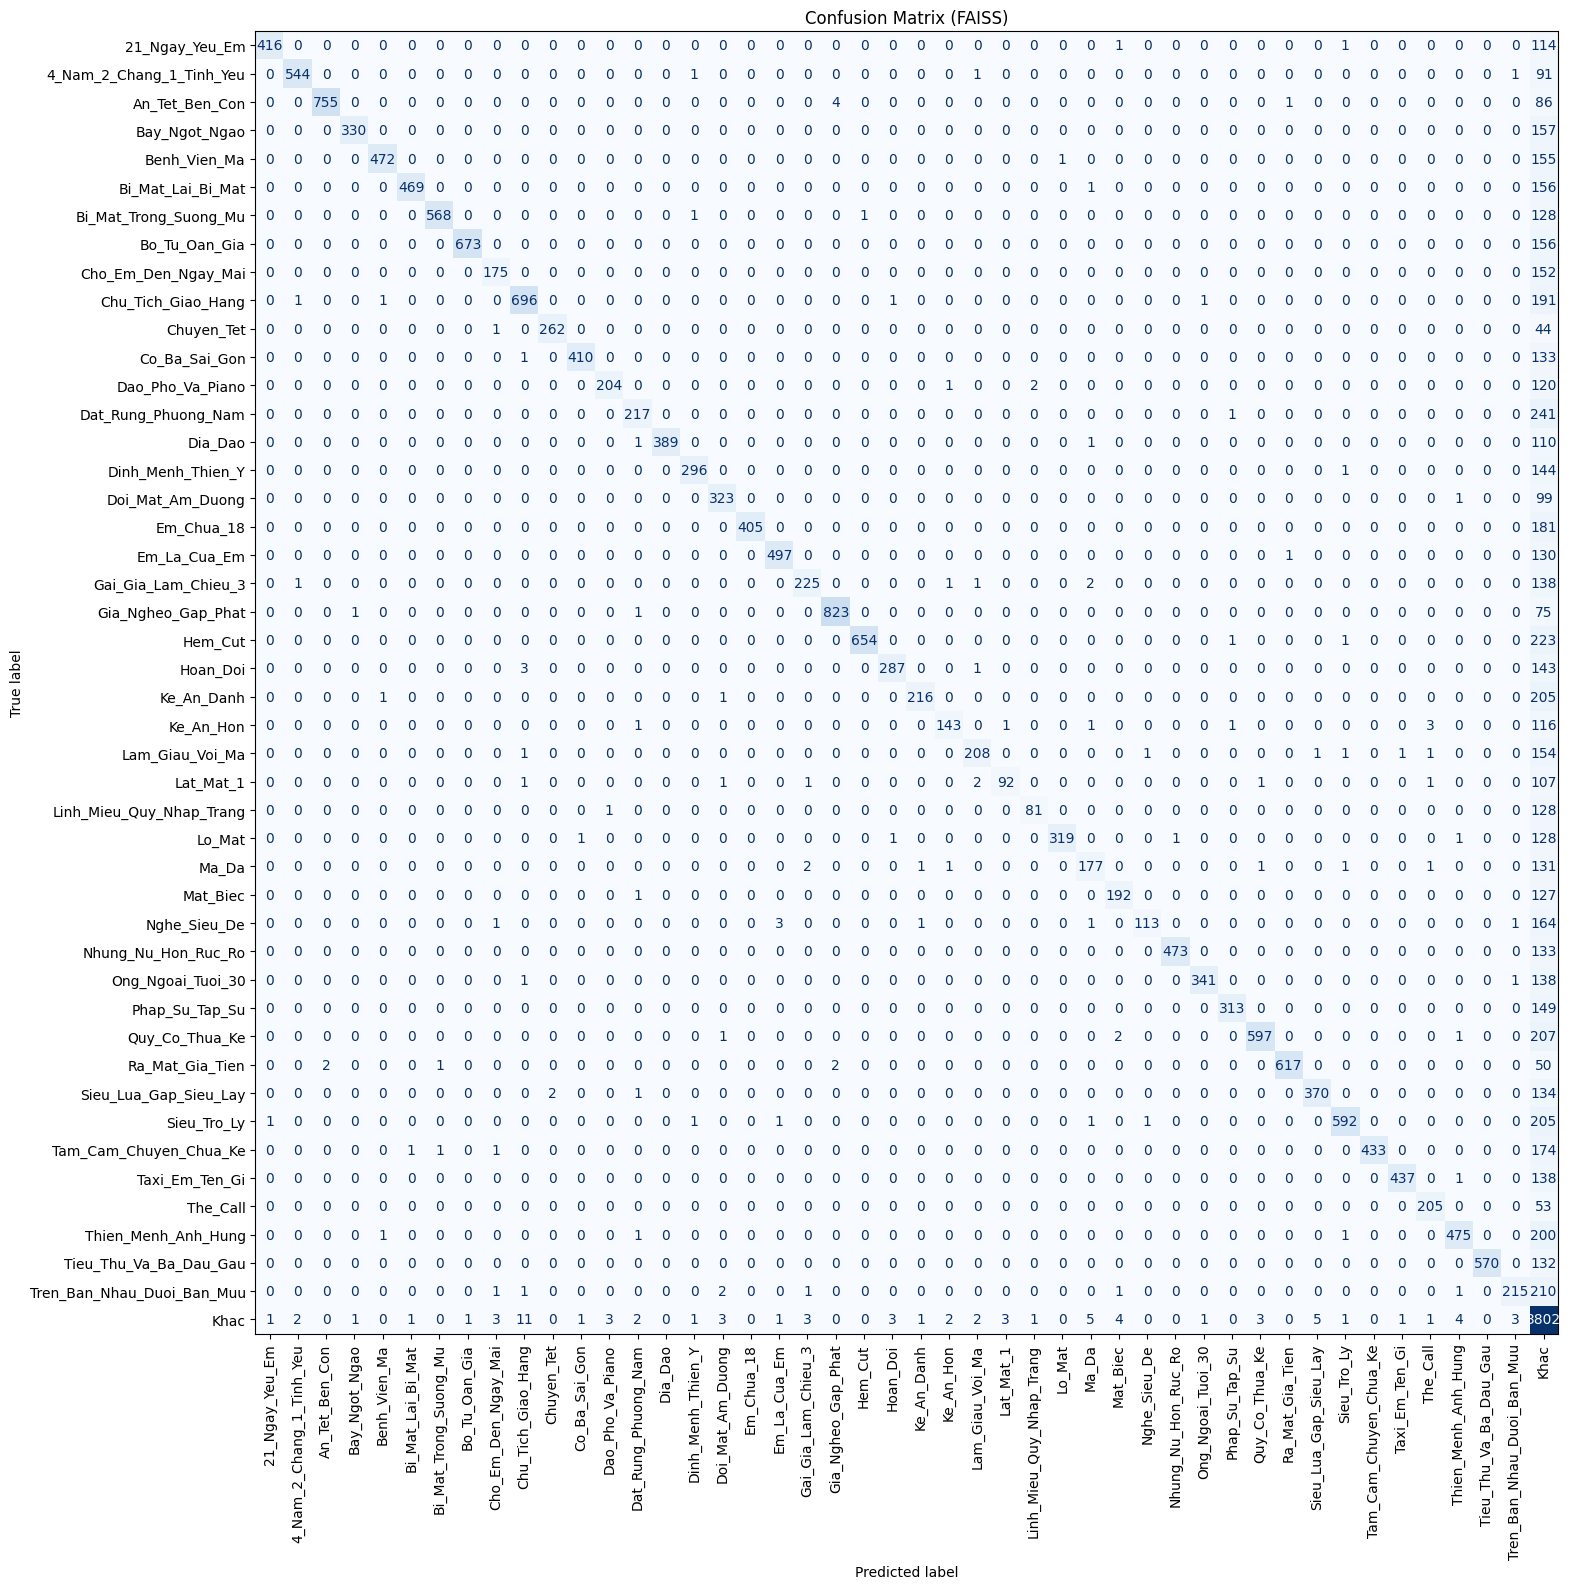


🖼️ Confusion matrix đã được lưu vào 'confusion_matrix_faiss.jpg'

📄 Classification Report:
                            precision    recall  f1-score  accuracy
21_Ngay_Yeu_Em               0.995215  0.781955  0.875789   0.76311
4_Nam_2_Chang_1_Tinh_Yeu     0.992701  0.852665  0.917369   0.76311
An_Tet_Ben_Con               0.997358  0.892435  0.941984   0.76311
Bay_Ngot_Ngao                0.993976  0.677618  0.805861   0.76311
Benh_Vien_Ma                 0.993684  0.751592  0.855848   0.76311
Bi_Mat_Lai_Bi_Mat            0.995754  0.749201  0.855059   0.76311
Bi_Mat_Trong_Suong_Mu        0.996491  0.813754  0.895899   0.76311
Bo_Tu_Oan_Gia                0.998516  0.811821  0.895542   0.76311
Cho_Em_Den_Ngay_Mai          0.961538  0.535168  0.687623   0.76311
Chu_Tich_Giao_Hang           0.973427  0.781145  0.866750   0.76311
Chuyen_Tet                   0.992424  0.853420  0.917688   0.76311
Co_Ba_Sai_Gon                0.995146  0.753676  0.857741   0.76311
Dao_Pho_Va_Piano        

In [9]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/processed-frames-224/Process_Frames_1/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.8  

# ==== Load mô hình và FAISS index ====
# Load mô hình EffcientNetB4
model = EfficientNetB4(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu",
    46: "Khac"
}
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")

# InceptionV3 + FAISS Index

In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Giả sử biến train_df là tf.data.Dataset đã chuẩn hóa và batch đúng
num_batches = tf.data.experimental.cardinality(train_df).numpy()
strategy = tf.distribute.MirroredStrategy()

# Khởi tạo InceptionV3 trong context của strategy
with strategy.scope():
    base_model_inceptionv3 = InceptionV3(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Trích đặc trưng và nhãn
all_features = []
all_labels = []

for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features with InceptionV3"):
    images_pp = preprocess_input(images)
    features_batch = base_model_inceptionv3(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

features_array = np.concatenate(all_features, axis=0)   
labels_array = np.concatenate(all_labels, axis=0)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Extracting features with InceptionV3: 100%|██████████| 702/702 [03:25<00:00,  3.42it/s]


In [13]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

Đã thêm 89852 vector đã chuẩn hóa vào FAISS index.


In [ ]:
# Đọc lại FAISS index và nhãn
index = faiss.read_index("faiss_features.index")
labels_array = np.load("faiss_labels.npy")

In [ ]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/processed-frames-224/Process_Frames_1/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.8  

# ==== Load mô hình và FAISS index ====
# Load mô hình InceptionV3
model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu",
    46: "Khac"
}
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")

✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 89852
   - Kích thước vector: 2048


Testing with FAISS:  54%|█████▍    | 14951/27612 [34:22<29:58,  7.04it/s]  

# VGG16 + FAISS Index

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Số batch
num_batches = tf.data.experimental.cardinality(train_df).numpy()

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    base_model_vgg16 = VGG16(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Nơi lưu đặc trưng và nhãn
all_features = []
all_labels = []

for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features"):
    images_pp = preprocess_input(images)
    features_batch = base_model_vgg16(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

# Nối đặc trưng và nhãn
features_array = np.concatenate(all_features, axis=0)
labels_array = np.concatenate(all_labels, axis=0)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features: 100%|██████████| 702/702 [01:28<00:00,  7.90it/s]


In [16]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

Đã thêm 89852 vector đã chuẩn hóa vào FAISS index.


In [ ]:
# Đọc lại FAISS index và nhãn
index = faiss.read_index("faiss_features.index")
labels_array = np.load("faiss_labels.npy")

✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 89852
   - Kích thước vector: 512


Testing with FAISS: 100%|██████████| 27612/27612 [39:09<00:00, 11.75it/s] 



✅ Accuracy: 85.98%
✅ Đúng: 23740 / ❌ Sai: 3872

⏱️ Thời gian xử lý trung bình: 0.0847 giây/ảnh
⏱️ Tổng thời gian xử lý: 2337.92 giây cho 27612 ảnh


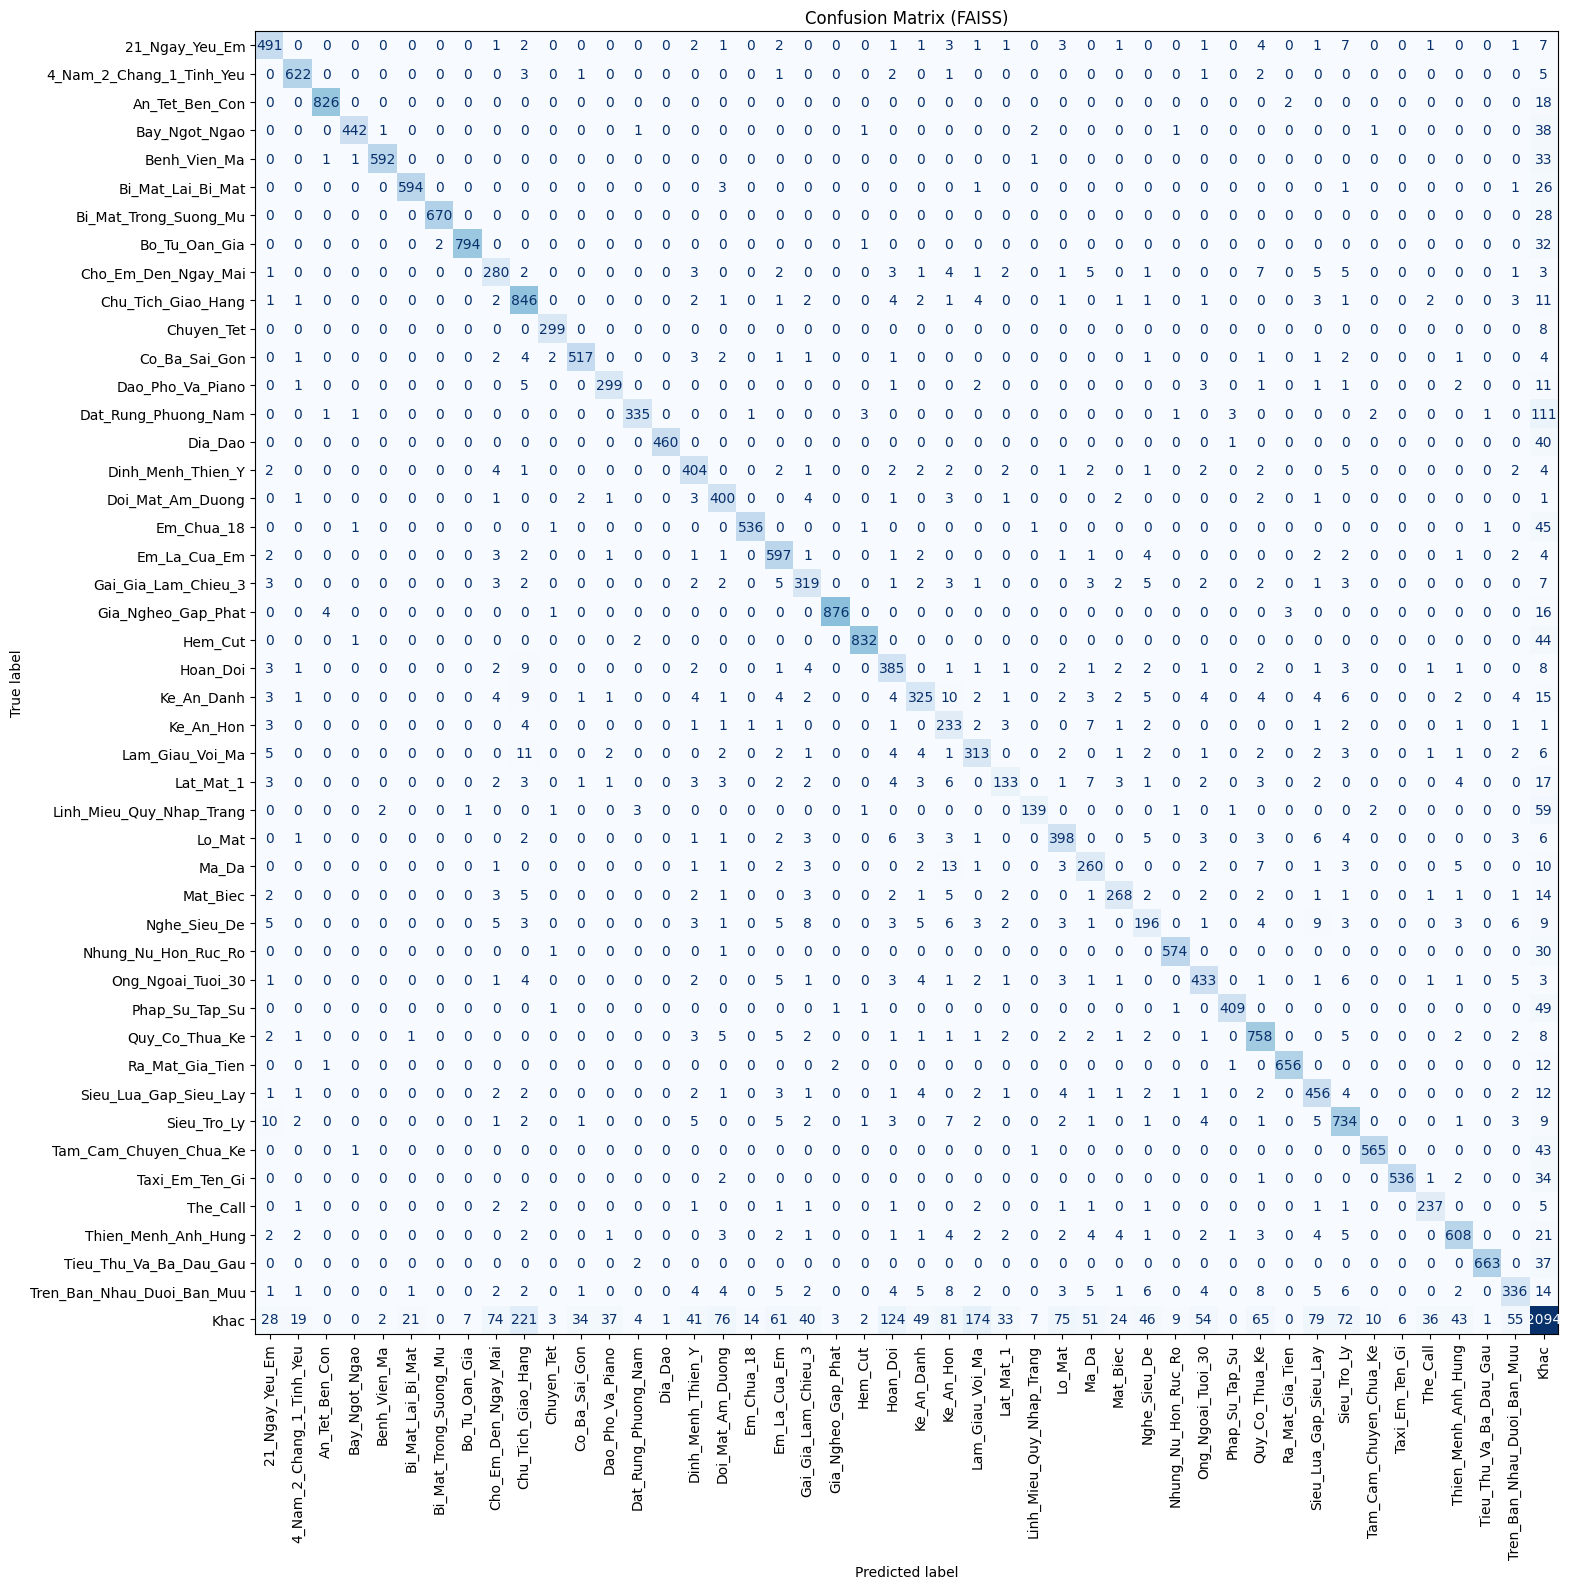


🖼️ Confusion matrix đã được lưu vào 'confusion_matrix_faiss.jpg'

📄 Classification Report:
                            precision    recall  f1-score  accuracy
21_Ngay_Yeu_Em               0.862917  0.922932  0.891916  0.859771
4_Nam_2_Chang_1_Tinh_Yeu     0.948171  0.974922  0.961360  0.859771
An_Tet_Ben_Con               0.991597  0.976359  0.983919  0.859771
Bay_Ngot_Ngao                0.988814  0.907598  0.946467  0.859771
Benh_Vien_Ma                 0.991625  0.942675  0.966531  0.859771
Bi_Mat_Lai_Bi_Mat            0.962723  0.948882  0.955752  0.859771
Bi_Mat_Trong_Suong_Mu        0.997024  0.959885  0.978102  0.859771
Bo_Tu_Oan_Gia                0.990025  0.957780  0.973636  0.859771
Cho_Em_Den_Ngay_Mai          0.708861  0.856269  0.775623  0.859771
Chu_Tich_Giao_Hang           0.736934  0.949495  0.829819  0.859771
Chuyen_Tet                   0.967638  0.973941  0.970779  0.859771
Co_Ba_Sai_Gon                0.926523  0.950368  0.938294  0.859771
Dao_Pho_Va_Piano        

In [17]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/processed-frames-224/Process_Frames_1/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.8  

# ==== Load mô hình và FAISS index ====
# Load mô hình InceptionV3
model = VGG16(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu",
    46: "Khac"
}
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")

# SIFT + FAISS Index

In [15]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

# ----------- Cấu hình ----------
image_size = 224
n_clusters = 224
train_path = '/kaggle/input/processed-frames-224/Process_Frames_1/Train'
random.seed(42)

# Mapping thủ công (1-indexed → tên class)
classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu"
}

# ----------- Tiền xử lý ----------
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)
    
# Hàm làm nét ảnh
def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# Tăng tương phản bằng CLAHE
def enhance_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced = cv2.merge((cl, a, b))
    return cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

# Làm mờ nền nhẹ (giữ cạnh rõ)
def blur_background(img, strength=15):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    mask = cv2.dilate(edges, None, iterations=2)
    mask = cv2.GaussianBlur(mask, (21, 21), 0)
    mask = cv2.normalize(mask.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    blurred = cv2.GaussianBlur(img, (strength, strength), 0)
    result = (mask[..., None] * img + (1 - mask[..., None]) * blurred).astype(np.uint8)
    return result

# Hàm tiền xử lý tổng hợp
def preprocess_image(img):
    img = increase_brightness(img, value=20)
    img = sharpen_image(img)
    # img = blur_background(img, strength=11)
    return img

num_images = sum(len(files) for _, _, files in os.walk(train_path) if files)
max_descriptors = num_images * 75
print(f"📸 Tổng số ảnh: {num_images}, tối đa descriptor dùng để huấn luyện: {max_descriptors}")

# ----------- Khởi tạo ----------
sift = cv2.SIFT_create(
    nfeatures=800,          
    nOctaveLayers=4,          
    contrastThreshold=0.02,   
    edgeThreshold=10,         
    sigma=1.4                 
)
descriptors_pool = []
image_descriptors = []
image_labels = []

# ----------- Bước 1: Trích xuất descriptor ----------
print("🧩 Trích xuất SIFT từ ảnh...")
for label_id, label_name in classes.items():
    label_dir = os.path.join(train_path, label_name)
    if not os.path.isdir(label_dir):
        continue
    for filename in tqdm(os.listdir(label_dir), desc=f"Processing {label_name}"):
        img_path = os.path.join(label_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (image_size, image_size))
        img = preprocess_image(img) 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None and len(descriptors) > 0:
            image_descriptors.append(descriptors)
            image_labels.append(label_id - 1)
            sampled = descriptors
            if len(descriptors_pool) < max_descriptors:
                if len(descriptors) > 100:
                    indices = np.random.choice(len(descriptors), 100, replace=False)
                    sampled = descriptors[indices]
                descriptors_pool.extend(sampled)

# ----------- Bước 2: Huấn luyện MiniBatchKMeans ----------
print("🏗️ Huấn luyện MiniBatchKMeans...")
descriptors_array = np.array(descriptors_pool)
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init=10, 
                         batch_size=4096, max_iter=200, verbose=1,
                        init_size=3 * n_clusters,
                        tol=1e-3,
                        max_no_improvement=10)
kmeans.fit(descriptors_array)

# ----------- Bước 3: Lưu mô hình ONNX ----------
print("💾 Chuyển và lưu KMeans sang ONNX...")
initial_type = [('input', FloatTensorType([None, descriptors_array.shape[1]]))]
onnx_model = convert_sklearn(kmeans, initial_types=initial_type)
onnx.save_model(onnx_model, "kmeans_model.onnx")

# ----------- Bước 4: Tạo histogram đặc trưng ----------
print("📦 Chuyển descriptor thành vector đặc trưng...")
def extract_bow_histogram(descriptors, kmeans_model, n_clusters):
    hist = np.zeros(n_clusters)
    if descriptors is not None and len(descriptors) > 0:
        clusters = kmeans_model.predict(descriptors)
        for c in clusters:
            hist[c] += 1
        hist = normalize(hist.reshape(1, -1), norm='l2')[0]
    return hist

features_array = np.array([
    extract_bow_histogram(des, kmeans, n_clusters)
    for des in image_descriptors
])

labels_array = np.array(image_labels)

# ----------- Kết quả ----------
print("✅ Hoàn tất trích đặc trưng.")
print("features_array shape:", features_array.shape)
print("labels_array shape:", labels_array.shape)
print("📝 Mô hình KMeans đã được lưu ở: kmeans_model.onnx")

📸 Tổng số ảnh: 89852, tối đa descriptor dùng để huấn luyện: 6738900
🧩 Trích xuất SIFT từ ảnh...


Processing Tren_Ban_Nhau_Duoi_Ban_Muu: 100%|██████████| 1428/1428 [00:13<00:00, 106.52it/s]


🏗️ Huấn luyện MiniBatchKMeans...
Init 1/10 with method k-means++
Inertia for init 1/10: 49786432.0
Init 2/10 with method k-means++
Inertia for init 2/10: 48887068.0
Init 3/10 with method k-means++
Inertia for init 3/10: 49212576.0
Init 4/10 with method k-means++
Inertia for init 4/10: 48687144.0
Init 5/10 with method k-means++
Inertia for init 5/10: 49090888.0
Init 6/10 with method k-means++
Inertia for init 6/10: 49796804.0
Init 7/10 with method k-means++
Inertia for init 7/10: 49624048.0
Init 8/10 with method k-means++
Inertia for init 8/10: 49032456.0
Init 9/10 with method k-means++
Inertia for init 9/10: 49524556.0
Init 10/10 with method k-means++
Inertia for init 10/10: 49298620.0
Minibatch step 1/329048: mean batch inertia: 129418.375
Minibatch step 2/329048: mean batch inertia: 89518.203125, ewa inertia: 89518.203125
Minibatch step 3/329048: mean batch inertia: 87651.8671875, ewa inertia: 89515.9343606088
Minibatch step 4/329048: mean batch inertia: 86898.28125, ewa inertia: 895

In [16]:
import faiss

print("🔍 Tích hợp với FAISS...")

# Chuyển đổi kiểu dữ liệu và chuẩn hóa L2
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)

print(f"✅ Đã thêm {index.ntotal} vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

print("💾 Đã lưu FAISS index và labels:")
print("- faiss_features.index")
print("- faiss_labels.npy")

# ----------- Kết quả ----------
print("✅ Hoàn tất trích đặc trưng và tích hợp FAISS.")
print("features_array shape:", features_array.shape)
print("labels_array shape:", labels_array.shape)
print("normalized_features shape:", normalized_features.shape)
print("FAISS index dimension:", d)
print("Total vectors in index:", index.ntotal)

🔍 Tích hợp với FAISS...
✅ Đã thêm 89822 vector đã chuẩn hóa vào FAISS index.
💾 Đã lưu FAISS index và labels:
- faiss_features.index
- faiss_labels.npy
✅ Hoàn tất trích đặc trưng và tích hợp FAISS.
features_array shape: (89822, 128)
labels_array shape: (89822,)
normalized_features shape: (89822, 128)
FAISS index dimension: 128
Total vectors in index: 89822


✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 89822
   - Kích thước vector: 128
✅ KMeans ONNX model đã được tải thành công!
📸 Tổng số ảnh test: 27612


Testing with SIFT+FAISS: 100%|██████████| 27612/27612 [07:52<00:00, 58.41it/s]



✅ SIFT+FAISS Results:
   📊 Accuracy: 26.46%
   ✅ Đúng: 7306 / ❌ Sai: 20306

⏱️ Performance:
   🚀 Thời gian xử lý trung bình: 0.0169 giây/ảnh
   ⏱️ Tổng thời gian xử lý: 467.80 giây cho 27612 ảnh


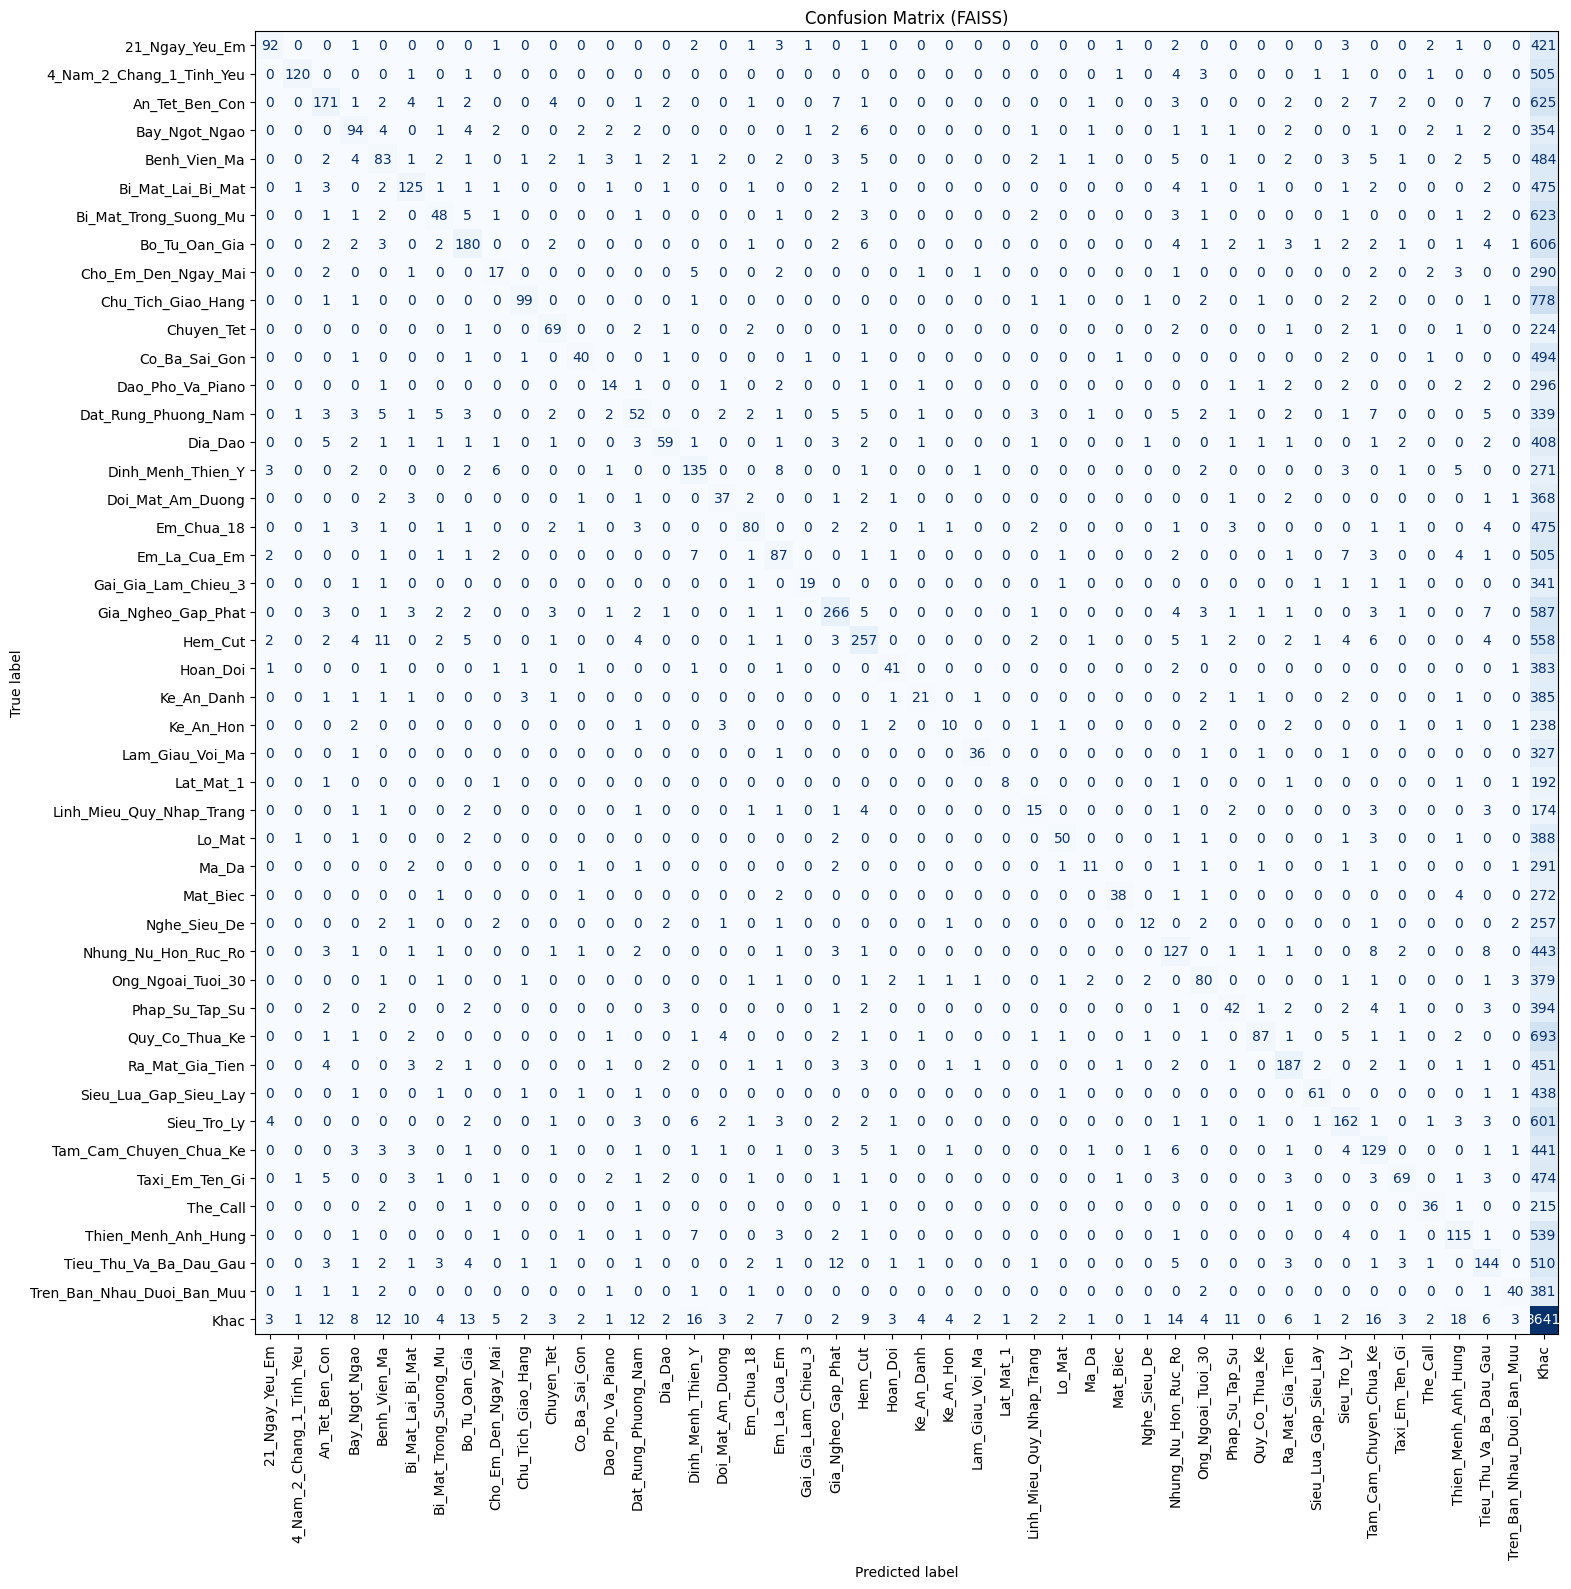


🖼️ Confusion matrix đã được lưu vào 'confusion_matrix_sift_faiss.jpg'

📄 Classification Report:
                            precision  recall  f1-score     support
21_Ngay_Yeu_Em                 0.8598  0.1729    0.2879    532.0000
4_Nam_2_Chang_1_Tinh_Yeu       0.9524  0.1881    0.3141    638.0000
An_Tet_Ben_Con                 0.7467  0.2021    0.3181    846.0000
Bay_Ngot_Ngao                  0.6573  0.1930    0.2984    487.0000
Benh_Vien_Ma                   0.5570  0.1322    0.2136    628.0000
Bi_Mat_Lai_Bi_Mat              0.7485  0.1997    0.3153    626.0000
Bi_Mat_Trong_Suong_Mu          0.5926  0.0688    0.1232    698.0000
Bo_Tu_Oan_Gia                  0.7531  0.2171    0.3371    829.0000
Cho_Em_Den_Ngay_Mai            0.4048  0.0520    0.0921    327.0000
Chu_Tich_Giao_Hang             0.9000  0.1111    0.1978    891.0000
Chuyen_Tet                     0.7340  0.2248    0.3441    307.0000
Co_Ba_Sai_Gon                  0.7547  0.0735    0.1340    544.0000
Dao_Pho_Va_Piano   

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import onnxruntime as ort

# Cài đặt các tham số
image_size = 224
n_clusters = 224
test_path = "/kaggle/input/processed-frames-224/Process_Frames_1/Test"
index_path = "faiss_features.index"
label_path = "faiss_labels.npy"
kmeans_path = "kmeans_model.onnx"  # Đường dẫn lưu mô hình KMeans ONNX
confusion_output_path = "confusion_matrix_sift_faiss.jpg"
csv_output_path = "classification_report_sift_faiss.csv"
similarity_threshold = 0.8

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # epsilon tránh chia cho 0

# Hàm trích xuất đặc trưng SIFT BOW cho một ảnh
def extract_sift_bow_features(img_path, sift_detector, kmeans_session, n_clusters):
    """Trích xuất đặc trưng SIFT BOW cho một ảnh"""
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        img = cv2.resize(img, (image_size, image_size))
        img = preprocess_image(img) 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        keypoints, descriptors = sift_detector.detectAndCompute(gray, None)

        if descriptors is None or len(descriptors) == 0:
            return np.zeros(n_clusters, dtype=np.float32)

        # Dự đoán cluster bằng KMeans ONNX
        input_name = kmeans_session.get_inputs()[0].name
        clusters = kmeans_session.run(None, {input_name: descriptors.astype(np.float32)})[0]

        # clusters là mảng nhãn cluster mỗi descriptor
        hist = np.zeros(n_clusters)
        for c in clusters:
            hist[int(c)] += 1

        # Chuẩn hóa L2
        hist = normalize(hist.reshape(1, -1), norm='l2')[0]
        return hist.astype(np.float32)

    except Exception as e:
        print(f"Lỗi trích xuất đặc trưng từ {img_path}: {e}")
        return None

# ==== Load FAISS index, labels, và KMeans ONNX model ====
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
    exit()
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")
    exit()
if not os.path.exists(kmeans_path):
    print(f"❌ Không tìm thấy KMeans ONNX model tại: {kmeans_path}")
    exit()

try:
    # Load FAISS index
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    # Load KMeans ONNX model
    kmeans_session = ort.InferenceSession(kmeans_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
    print(f"✅ KMeans ONNX model đã được tải thành công!")

except Exception as e:
    print(f"❌ Lỗi khi tải models: {e}")
    exit()

# ==== Khởi tạo SIFT detector ====
sift = cv2.SIFT_create(
    nfeatures=1000,          
    nOctaveLayers=4,          
    contrastThreshold=0.02,   
    edgeThreshold=10,         
    sigma=1.4                 
)

# ==== Mapping classes ====
classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu",
    46: "Khac"
}
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []

for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

print(f"📸 Tổng số ảnh test: {len(all_images)}")

# ==== Dự đoán ====
processing_times = []

for img_path in tqdm(all_images, desc="Testing with SIFT+FAISS"):
    try:
        start_time = time.time()
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue

        feature = extract_sift_bow_features(img_path, sift, kmeans_session, n_clusters)
        if feature is None:
            print(f"❌ Không thể trích xuất đặc trưng từ: {img_path}")
            continue

        feature = feature / (np.linalg.norm(feature) + 1e-10)
        feature = feature.reshape(1, -1).astype(np.float32)

        D, I = index.search(feature, 1)

        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared / 2

        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data) + 1

        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)

        end_time = time.time()
        processing_times.append(end_time - start_time)

    except Exception as e:
        print(f"❌ Lỗi xử lý ảnh {img_path}: {e}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    
    print(f"\n✅ SIFT+FAISS Results:")
    print(f"   📊 Accuracy: {accuracy * 100:.2f}%")
    print(f"   ✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Performance:")
    print(f"   🚀 Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"   ⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=4, output_dict=True, zero_division=0
    )
    
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    
    # Hiển thị báo cáo
    print(report_df[["precision", "recall", "f1-score", "support"]].round(4))
    
    # Các tham số đánh giá chung
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']
    
    print(f"\n📝 Tổng kết đánh giá (SIFT+FAISS):")
    print(f"   🎯 Accuracy: {accuracy * 100:.2f}%")
    print(f"   📊 Macro Precision: {macro_avg['precision']:.4f}")
    print(f"   📊 Macro Recall: {macro_avg['recall']:.4f}")
    print(f"   📊 Macro F1-score: {macro_avg['f1-score']:.4f}")
    print(f"   📊 Weighted Precision: {weighted_avg['precision']:.4f}")
    print(f"   📊 Weighted Recall: {weighted_avg['recall']:.4f}")
    print(f"   📊 Weighted F1-score: {weighted_avg['f1-score']:.4f}")
    print(f"   🚀 Avg Processing Time: {avg_processing_time:.4f} sec/image")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'accuracy': accuracy,
        'macro_precision': macro_avg['precision'],
        'macro_recall': macro_avg['recall'],
        'macro_f1_score': macro_avg['f1-score'],
        'weighted_precision': weighted_avg['precision'],
        'weighted_recall': weighted_avg['recall'],
        'weighted_f1_score': weighted_avg['f1-score'],
        'avg_processing_time': avg_processing_time,
        'total_images': len(processing_times),
        'similarity_threshold': similarity_threshold,
        'n_clusters': n_clusters
    }
    
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_sift_faiss.csv', index=False)
    print(f"📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_sift_faiss.csv'")
    
    # Lưu báo cáo cuối cùng
    final_df = report_df.copy()
    for key, value in evaluation_metrics.items():
        final_df[key] = value
    
    final_df.to_csv('final_classification_report_sift_faiss.csv', index=True)
    print(f"📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_sift_faiss.csv'")
    
    print(f"\n🎉 Hoàn tất đánh giá với SIFT+FAISS!")

# HOG + FAISS Index

In [13]:
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize

# ----------- Cấu hình ----------
image_size = 224
train_path = '/kaggle/input/processed-frames-224/Process_Frames_1/Train'
random.seed(42)

classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu"
}

# ----------- Trích xuất HOG ----------
print("📸 Trích xuất HOG từ ảnh...")
hog_features = []
hog_labels = []

for label_id, label_name in classes.items():
    label_dir = os.path.join(train_path, label_name)
    if not os.path.isdir(label_dir):
        continue
    for filename in tqdm(os.listdir(label_dir), desc=f"Processing {label_name}"):
        img_path = os.path.join(label_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_resized = resize(img, (image_size, image_size), anti_aliasing=True)
        gray = rgb2gray(img_resized)

        # Trích HOG
        features = hog(
            gray,
            orientations=8,                
            pixels_per_cell=(16, 16),       
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            feature_vector=True
        )
        hog_features.append(features)
        hog_labels.append(label_id - 1)

hog_features = np.array(hog_features)
hog_labels = np.array(hog_labels)
print("✅ Trích xuất HOG hoàn tất.")
print("HOG feature shape:", hog_features.shape)
print("Labels shape:", hog_labels.shape)

📸 Trích xuất HOG từ ảnh...


Processing Tren_Ban_Nhau_Duoi_Ban_Muu: 100%|██████████| 1428/1428 [00:16<00:00, 87.30it/s]


✅ Trích xuất HOG hoàn tất.
HOG feature shape: (89852, 1568)
Labels shape: (89852,)


In [14]:
import faiss

print("🔍 Tích hợp với FAISS...")

# Chuyển đổi kiểu dữ liệu và chuẩn hóa L2
normalized_features = l2_normalize(hog_features.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)

print(f"✅ Đã thêm {index.ntotal} vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", hog_labels)

print("💾 Đã lưu FAISS index và labels:")
print("- faiss_features.index")
print("- faiss_labels.npy")

# ----------- Kết quả ----------
print("✅ Hoàn tất trích đặc trưng và tích hợp FAISS.")
print("features_array shape:", hog_features.shape)
print("labels_array shape:", hog_labels.shape)
print("normalized_features shape:", normalized_features.shape)
print("FAISS index dimension:", d)
print("Total vectors in index:", index.ntotal)

🔍 Tích hợp với FAISS...
✅ Đã thêm 89852 vector đã chuẩn hóa vào FAISS index.
💾 Đã lưu FAISS index và labels:
- faiss_features.index
- faiss_labels.npy
✅ Hoàn tất trích đặc trưng và tích hợp FAISS.
features_array shape: (89852, 1568)
labels_array shape: (89852,)
normalized_features shape: (89852, 1568)
FAISS index dimension: 1568
Total vectors in index: 89852


✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 89852
   - Kích thước vector: 1568
📸 Tổng số ảnh test: 27612


Testing with HOG+FAISS: 100%|██████████| 27612/27612 [29:11<00:00, 15.76it/s]



✅ HOG+FAISS Results:
   📊 Accuracy: 77.28%
   ✅ Đúng: 21339 / ❌ Sai: 6273

⏱️ Performance:
   🚀 Thời gian xử lý trung bình: 0.0629 giây/ảnh
   ⏱️ Tổng thời gian xử lý: 1737.39 giây cho 27612 ảnh


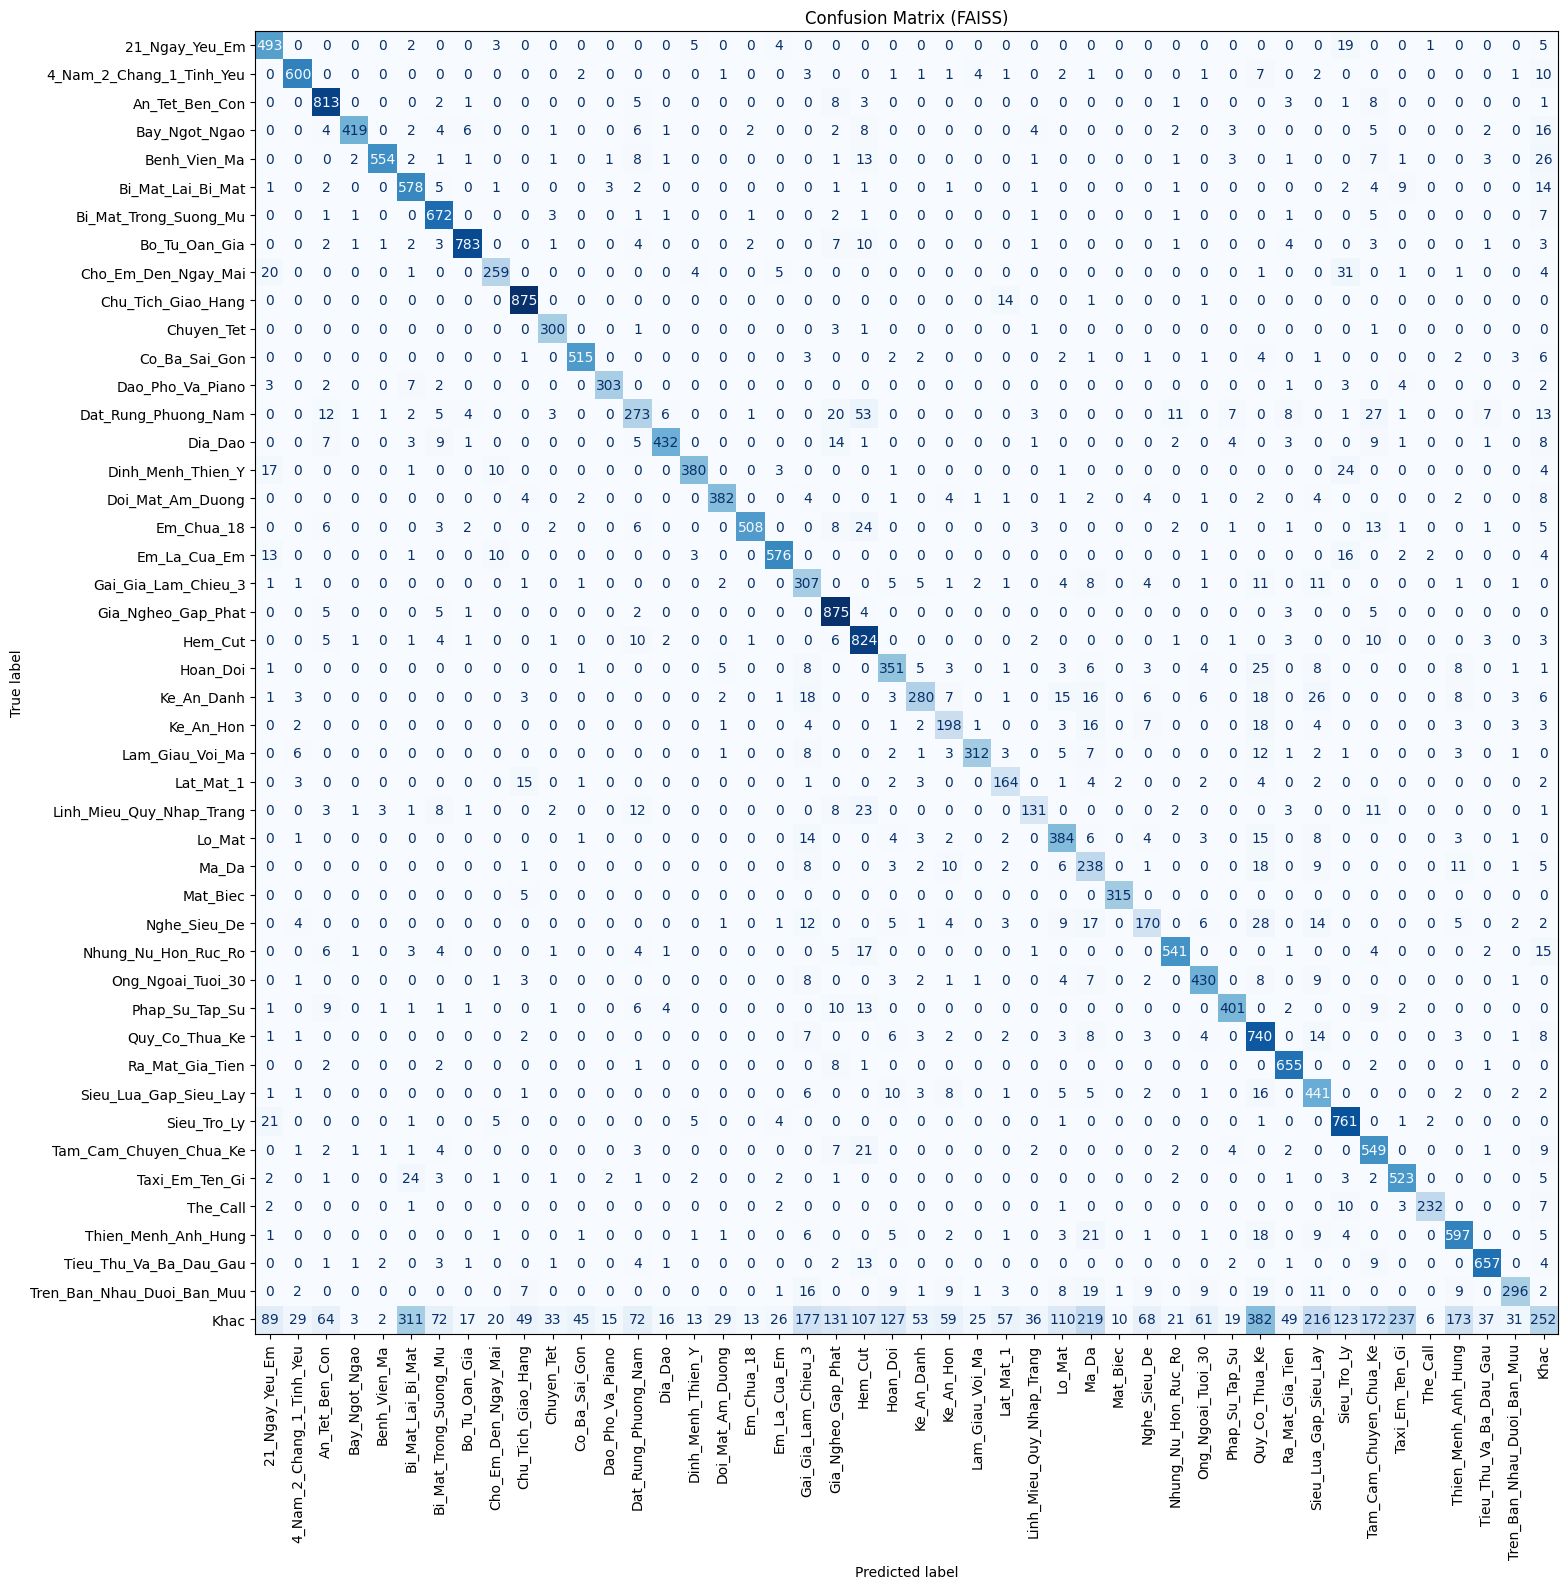


🖼️ Confusion matrix đã được lưu vào 'confusion_matrix_hog_faiss.jpg'

📄 Classification Report:
                            precision  recall  f1-score     support
21_Ngay_Yeu_Em                 0.7380  0.9267    0.8217    532.0000
4_Nam_2_Chang_1_Tinh_Yeu       0.9160  0.9404    0.9281    638.0000
An_Tet_Ben_Con                 0.8585  0.9610    0.9069    846.0000
Bay_Ngot_Ngao                  0.9699  0.8604    0.9119    487.0000
Benh_Vien_Ma                   0.9805  0.8822    0.9288    628.0000
Bi_Mat_Lai_Bi_Mat              0.6116  0.9233    0.7358    626.0000
Bi_Mat_Trong_Suong_Mu          0.8276  0.9628    0.8901    698.0000
Bo_Tu_Oan_Gia                  0.9549  0.9445    0.9497    829.0000
Cho_Em_Den_Ngay_Mai            0.8328  0.7920    0.8119    327.0000
Chu_Tich_Giao_Hang             0.9049  0.9820    0.9419    891.0000
Chuyen_Tet                     0.8547  0.9772    0.9119    307.0000
Co_Ba_Sai_Gon                  0.9051  0.9467    0.9254    544.0000
Dao_Pho_Va_Piano    

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
from skimage.feature import hog
from skimage import color
import traceback

# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/processed-frames-224/Process_Frames_1/Test"
index_path = "faiss_features.index"
label_path = "faiss_labels.npy"
confusion_output_path = "confusion_matrix_hog_faiss.jpg"
csv_output_path = "classification_report_hog_faiss.csv"
similarity_threshold = 0.8

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # epsilon tránh chia cho 0

# Hàm trích xuất đặc trưng HOG BOW cho một ảnh
def extract_hog_features(img_path):
    """Trích xuất vector HOG trực tiếp từ ảnh"""
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        img = cv2.resize(img, (image_size, image_size))
        gray = color.rgb2gray(img)

        # Trích xuất đặc trưng HOG (vector 1 chiều)
        hog_vector = hog(gray,
                        orientations=8,                
                        pixels_per_cell=(16, 16),       
                        cells_per_block=(2, 2),
                        block_norm='L2-Hys',
                        feature_vector=True)

        if hog_vector is None or len(hog_vector) == 0:
            return None

        return hog_vector.astype(np.float32)

    except Exception as e:
        print(f"Lỗi trích xuất HOG từ {img_path}: {e}")
        return None

# ==== Load FAISS index, labels ====
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
    exit()
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")
    exit()

try:
    # Load FAISS index
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")

except Exception as e:
    exit()

# ==== Mapping classes ====
classes = {
    1: "21_Ngay_Yeu_Em", 2: "4_Nam_2_Chang_1_Tinh_Yeu", 3: "An_Tet_Ben_Con", 4: "Bay_Ngot_Ngao", 5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat", 7: "Bi_Mat_Trong_Suong_Mu", 8: "Bo_Tu_Oan_Gia", 9: "Cho_Em_Den_Ngay_Mai", 10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet", 12: "Co_Ba_Sai_Gon", 13: "Dao_Pho_Va_Piano", 14: "Dat_Rung_Phuong_Nam", 15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y", 17: "Doi_Mat_Am_Duong", 18: "Em_Chua_18", 19: "Em_La_Cua_Em", 20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat", 22: "Hem_Cut", 23: "Hoan_Doi", 24: "Ke_An_Danh", 25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma", 27: "Lat_Mat_1", 28: "Quy_Cau", 29: "Lo_Mat", 30: "Ma_Da",
    31: "Mat_Biec", 32: "Nghe_Sieu_De", 33: "Nhung_Nu_Hon_Ruc_Ro", 34: "Ong_Ngoai_Tuoi_30", 35: "Phap_Su_Tap_Su",
    36: "Quy_Co_Thua_Ke", 37: "Ra_Mat_Gia_Tien", 38: "Sieu_Lua_Gap_Sieu_Lay", 39: "Sieu_Tro_Ly", 40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi", 42: "The_Call", 43: "Thien_Menh_Anh_Hung", 44: "Tieu_Thu_Va_Ba_Dau_Gau", 45: "Tren_Ban_Nhau_Duoi_Ban_Muu",
    46: "Khac"
}
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []

for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

print(f"📸 Tổng số ảnh test: {len(all_images)}")

# ==== Dự đoán ====
processing_times = []

for img_path in tqdm(all_images, desc="Testing with HOG+FAISS"):
    try:
        start_time = time.time()
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue

        # Trích xuất vector HOG trực tiếp
        feature = extract_hog_features(img_path)

        if feature is None:
            print(f"❌ Không thể trích xuất đặc trưng từ: {img_path}")
            continue

        # Kiểm tra kích thước vector
        if feature.shape[0] != index.d:
            print(f"⚠️ Vector không đúng kích thước ({feature.shape[0]} vs {index.d}) tại: {img_path}")
            continue

        # Chuẩn hóa L2
        feature = feature / (np.linalg.norm(feature) + 1e-10)
        feature = feature.reshape(1, -1).astype(np.float32)

        # Tìm ảnh gần nhất trong FAISS index
        D, I = index.search(feature, 1)

        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared / 2

        if similarity_score < similarity_threshold:
            pred_label = 46  # "Khác"
        else:
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data) + 1

        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)

        end_time = time.time()
        processing_times.append(end_time - start_time)

    except Exception as e:
        print(f"❌ Lỗi xử lý ảnh {img_path}: {e}")
        traceback.print_exc()

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    
    print(f"\n✅ HOG+FAISS Results:")
    print(f"   📊 Accuracy: {accuracy * 100:.2f}%")
    print(f"   ✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Performance:")
    print(f"   🚀 Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"   ⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=4, output_dict=True, zero_division=0
    )
    
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    
    # Hiển thị báo cáo
    print(report_df[["precision", "recall", "f1-score", "support"]].round(4))
    
    # Các tham số đánh giá chung
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']
    
    print(f"\n📝 Tổng kết đánh giá (HOG+FAISS):")
    print(f"   🎯 Accuracy: {accuracy * 100:.2f}%")
    print(f"   📊 Macro Precision: {macro_avg['precision']:.4f}")
    print(f"   📊 Macro Recall: {macro_avg['recall']:.4f}")
    print(f"   📊 Macro F1-score: {macro_avg['f1-score']:.4f}")
    print(f"   📊 Weighted Precision: {weighted_avg['precision']:.4f}")
    print(f"   📊 Weighted Recall: {weighted_avg['recall']:.4f}")
    print(f"   📊 Weighted F1-score: {weighted_avg['f1-score']:.4f}")
    print(f"   🚀 Avg Processing Time: {avg_processing_time:.4f} sec/image")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'accuracy': accuracy,
        'macro_precision': macro_avg['precision'],
        'macro_recall': macro_avg['recall'],
        'macro_f1_score': macro_avg['f1-score'],
        'weighted_precision': weighted_avg['precision'],
        'weighted_recall': weighted_avg['recall'],
        'weighted_f1_score': weighted_avg['f1-score'],
        'avg_processing_time': avg_processing_time,
        'total_images': len(processing_times),
        'similarity_threshold': similarity_threshold,
        'n_clusters': n_clusters
    }
    
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_hog_faiss.csv', index=False)
    print(f"📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_hog_faiss.csv'")
    
    # Lưu báo cáo cuối cùng
    final_df = report_df.copy()
    for key, value in evaluation_metrics.items():
        final_df[key] = value
    
    final_df.to_csv('final_classification_report_hog_faiss.csv', index=True)
    print(f"📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_hog_faiss.csv'")
    
    print(f"\n🎉 Hoàn tất đánh giá với HOG+FAISS!")